### Montamos la unidad de drive - Importamos librerías y cargamos paths

In [28]:
from google.colab import drive
drive.mount('/content/drive/', force_remount=True)

from keras.utils import to_categorical
from keras import backend as K
from keras.models import Model, Sequential, load_model
from keras.layers import Input,LSTM
from keras.layers.core import Activation, Dense, Dropout
from keras.layers.normalization import BatchNormalization
from keras.optimizers import SGD

import pandas as pd
import numpy as np

Mounted at /content/drive/


In [0]:
# Instalar librería para pinitar mapa
!apt-get install libgeos-3.5.0
!apt-get install libgeos-dev
!pip install https://github.com/matplotlib/basemap/archive/master.zip

Reading package lists... Done
Building dependency tree       
Reading state information... Done
E: Unable to locate package libgeos-3.5.0
E: Couldn't find any package by glob 'libgeos-3.5.0'
E: Couldn't find any package by regex 'libgeos-3.5.0'
Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following package was automatically installed and is no longer required:
  libnvidia-common-430
Use 'apt autoremove' to remove it.
Suggested packages:
  libgdal-doc
The following NEW packages will be installed:
  libgeos-dev
0 upgraded, 1 newly installed, 0 to remove and 25 not upgraded.
Need to get 73.1 kB of archives.
After this operation, 486 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu bionic/universe amd64 libgeos-dev amd64 3.6.2-1build2 [73.1 kB]
Fetched 73.1 kB in 1s (50.9 kB/s)
Selecting previously unselected package libgeos-dev.
(Reading database ... 134443 files and directories currently installed.)
Pr

In [0]:
# Cambiar esta línea al directorio de trabajo pertinente
files_path = "/content/drive/My Drive/HARVIS_UC2/BBDD/FR1193_Toulouse_Seville/"

# Se usarán para predecir la trayectoria final a utilizar para elegir el modelo de regresión
metar1_path = 'metar_1_clean.csv'  # Archivo con info metar1
metar2_path = 'metar_2_clean.csv'  # Archivo con info metar2

# Datos de trayectoria completos juntos en un mismo archivo
traj_path = 'trajectories.csv' 

# Archivo con información de las predicciones 
#gt_path = 'gt_data.csv'
model_path = 'models/'     

### Global variables and methods

In [0]:
# Cargamos datos
traj = pd.read_csv(files_path + traj_path, sep=",")
#gt = pd.read_csv(files_path + gt_path, sep=",")
pred_model = load_model(files_path+model_path+'metar_model.h5')
metar_1_clean = pd.read_csv(files_path+metar1_path, sep=",") # 30 minutos antes de aterrizaje
metar_2_clean = pd.read_csv(files_path+metar2_path, sep=",") # Momento de aterrizaje

In [31]:
import re
variables = ['hour', 'minute', 'second', 'altitude', 'direction', 'latitude', 'longitude', 'speed']
for v in variables:
  n = 0
  for i in traj[v]:  
    result = re.search('\[(.*)\]', i)
    traj[v][n] = [float(j) for j in result.group(1).split(',')]
    n +=1

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys


In [0]:
# Normalizamos los datos de trayectoria respecto de los máximos y mínimos (no siguen una distribución gaussiana)
def normalize_data(x_data, min_value, max_value):
  # Normalizamos datos de entrada entre un mínimo y máximo para obtener un valor entre 0 y 1
  # x_data tiene shape = (samples, timestemps)
  x_diff = x_norm = np.zeros(x_data.shape)
  x_norm = (x_data-min_value)/(max_value-min_value)
  """for i in range(1,len(x_data)):
    x_diff[i] = x_norm[i]-x_norm[i-1]""" 
  return x_norm

# Denormalizar los datos para crear la predicción en valores (coordenadas y altitud) reales
def denormalize_data(norm_data, min_value, max_value):
  # Desormalizamos datos normalizados entre 0 y 1 para obtener entre mínimo y máximo 
  # x_data tiene shape = (samples, timestemps)
  x_diff = x_data = np.zeros(norm_data.shape)
  x_data = (norm_data*(max_value-min_value))+min_value
  """for i in range(1,len(x_data)):
    x_diff[i] = x_data[i]+x_data[i-1]""" 
  return x_data

# Estandarizamos los datos de metar respecto de la media y std de los datos de entrenamiento
def standarize_data(x_data):
  # Se utiliza la media y std de los datos de entrenamiento para estandarizar lso datos de test

  x_standarized = np.zeros(x_data.shape)

  for i in range(len(x_data.T)):
    std = np.std(x_data.T[i])
    if std ==0: std=1 # Si la std es 0, cambiamos por 1 para evitar dividir entre 0
    x_standarized.T[i] = (x_data.T[i]-np.mean(x_data.T[i]))/std
    
  return x_standarized

## TODO: modificar este método para que sea funcional en este caso y poder crear las particiones de test y train

# Mezclar datos de train y test y crear particiones
def shuffle_and_partition(x_traj, id_list, y, trainP):
  # x=inputs, y=outputs, trainP=porcentaje de train
  s = np.arange(x_traj.shape[0])
  np.random.shuffle(s)
  x_traj, id_list, y = x_traj[s], np.array(id_list)[s], y[s]

  # Asignamos particiones de train y test
  n_part = round(trainP*len(x_traj))

  x_traj_train, x_traj_test, id_list_train, id_list_test, y_train, y_test = x_traj[:n_part], x_traj[n_part:], id_list[:n_part], id_list[n_part:], y[:n_part], y[n_part:]
  return x_traj_train, x_traj_test, id_list_train, id_list_test, y_train, y_test

### Tratamiento datos de trayectoria

Pasamos las variables a formato float y hacemos el cambio de coordenadas

In [0]:
#cambio de coordenadas [latitud,longitud,altitud] -> [x,y,z]
x_coord,y_coord,z_coord = list(),list(),list()
a = 1378.137
b = 6356.752
e1 = (a**2 - b**2)/a**2
for i in range(len(traj['longitude'])):
  Nr = a/(1-e1*(np.sin(np.deg2rad(traj['longitude'][i])))**2)**0.5
  x_coord.append((Nr*(1-e1)+traj['altitude'][i])*np.sin(np.deg2rad(traj['longitude'][i])))
  y_coord.append((Nr+traj['altitude'][i])*np.cos(np.deg2rad(traj['longitude'][i]))*np.cos(np.deg2rad(traj['latitude'][i])))
  z_coord.append((Nr+traj['altitude'][i])*np.cos(np.deg2rad(traj['longitude'][i]))*np.sin(np.deg2rad(traj['latitude'][i])))
  #x.append()
fl_id_list = list(traj['fl_id'])
threshold = list(traj['threshold'])

In [34]:
maxz_coord = list()
for i in range(len(z_coord)):
  maxz_coord.append(max(z_coord[i]))
print(max(maxz_coord))

28687.12225097063


In [0]:
# Separar una serie de datos secuenciales de una sola variable en muestras diferentes y la salida - Preparación para LSTM univariate
def split_sequence(sequence, n_steps):
	X, y = list(), list()
	for i in range(len(sequence)):
		end_ix = i + n_steps # Fin de secuencia
		if end_ix > len(sequence)-1: # Comprobar si hemos rebasado el final
			break
		seq_x, seq_y = sequence[i:end_ix], sequence[end_ix] # Separar entre entrada y salida
		X.append(seq_x)
		y.append(seq_y)
	return np.array(X), np.array(y)


In [0]:
import numpy as np
# Separar una serie de datos secuenciales de una varas variables en muestras diferentes y la salida - Preparación para LSTM multivariate
def split_sequences(sequences, n_steps):
	X, y = list(), list()
	for i in range(len(sequences)):
		# find the end of this pattern
		end_ix = i + n_steps
		# check if we are beyond the dataset
		if end_ix > len(sequences)-1:
			break
		# gather input and output parts of the pattern
		seq_x, seq_y = sequences[i:end_ix, :], sequences[end_ix, :]
		X.append(seq_x)
		y.append(seq_y)
	return np.array(X), np.array(y)

### Obtención de las predicciones 

Preprocesado de la información metar para obtener las prediciones

In [0]:
def preprocess_metar(info_metar):
  data = []

  # Añadimos hora de aterrizaje
  hour, minute = info_metar['Land_Timestamp'].values[0].split('-')[-1].split('_')
  hour, minute = float(hour), float(minute)

  # Añadimos dirección del viento
  wind_dir_1 = info_metar['Wind_Dir'].values[0]
  # Si la direccción del viento es variable, anotamos este valor en una variable nueva
  if wind_dir_1 == 'VRB':
    wind_dir_1 = 0 ### Si el wind_dir es variable, ¿qué colocamos en la variable wind_dir? ¿NaN?
    variable_wind_dir_1 = 1
  else:
    wind_dir_1 = float(wind_dir_1)
    variable_wind_dir_1 = 0

  # Añadimos variación de la orientación del viento
  wd_max_1 = float(info_metar['Wind_Var_Max'])
  wd_min_1 = float(info_metar['Wind_Var_Min'])
  if str(wd_max_1) == 'nan':
    wd_max_1, wd_min_1 = wind_dir_1, wind_dir_1

  # Añadimos velocidad del viento
  wind_speed_1 = float(info_metar['Wind_Speed'])

  # Añadimos rachas de viento
  wind_gust_1 = float(info_metar['Wind_Gust'])
  if str(wind_gust_1) == 'nan':
    wind_gust_1 = wind_speed_1

  # Añadimos visibilidad
  vis_1 = float(info_metar['Visibility'])
  # Añadimos expected_visibility
  vis_2 = float(info_metar['Expected_Visibility'].values[0])
  if str(vis_2) == 'nan': vis_2 = vis_1
  # Añadimos temperatura
  temp_1 = float(info_metar['Temp'])
  # Añadimos dew-point
  dew_1 = float(info_metar['Dew_point'])
  # Añadimos presión
  pressure_1 = float(info_metar['Pressure'])
  # Añadimos campo CAVOK en forma one-hot encoding
  ck =  info_metar['CAVOK'].values
  if ck == 'CAVOK':
    CAVOK_1_list = [0,1]
  else:
    CAVOK_1_list = [1,0]
  # Añadimos el campo weather en forma one-hot encoding
  weather_1 = info_metar['Weather'].values
  
  possible_weathers = ['nan', 'NSW','-','+','BC','BL','BR','DR','DS','DU','DZ','FG','FC','FU','FZ','GR','GS','HZ','IC',
                        'MI','PL','PO','RA','SA','SG','SH','SN','SQ','SS','TS','VA','VC','UP','RE']
  weather_1_list = np.zeros(len(possible_weathers))
  n = 0
  for pw in possible_weathers:
    if pw in str(weather_1):
      weather_1_list[n] = 1
    n += 1
  # Añadimos el campo TEMPO en forma de one-hot encoding
  tempo_1 = info_metar['TEMPO'].values[0]
  possible_tempo = ['TEMPO', 'NOSIG']
  tempo_1_list = np.zeros(len(possible_tempo))
  n = 0
  for pt in possible_tempo:
    if pt in str(tempo_1):
      tempo_1_list[n] = 1
    n += 1
  # Añadimos el campo cloud en forma de one-hot encoding
  cloud_1 = info_metar['Cloud'].values[0]
  possible_clouds = ['nan', 'SKC', 'FEW', 'SCT', 'BKN', 'OVC']
  cloud_1_list = np.zeros(len(possible_clouds))
  n = 0
  for pc in possible_clouds:
    if pc in str(cloud_1):
      cloud_1_list[n] = 1
    n += 1
  # Añadimos el campo cloud-type en forma de one-hot encoding
  cloud_type_1 = info_metar['Cloud_Type'].values[0]
  possible_cloud_type = ['nan', 'CB', 'TCU', 'ACC', 'CLD', 'CBMAM']
  cloud_type_1_list = np.zeros(len(possible_cloud_type))
  n = 0
  for pct in possible_cloud_type:
    if pct in str(cloud_type_1):
      cloud_type_1_list[n] = 1
    n += 1

  # Añadimos cloud_altitude
  cloud_altitude_1 = float(info_metar['Cloud_Altitude'])
  if str(cloud_altitude_1) == 'nan': cloud_altitude_1 = 0


  # Añadimos datos a una lista
  data.append([hour, minute, wind_dir_1, variable_wind_dir_1, wd_max_1, wd_min_1, wind_speed_1, wind_gust_1, vis_1, vis_2, temp_1, dew_1, pressure_1, cloud_altitude_1])
  # Añadimos datos guardados en arrays en one-hot encoding
  data[-1].extend(CAVOK_1_list)
  data[-1].extend(weather_1_list)
  data[-1].extend(tempo_1_list)
  data[-1].extend(cloud_1_list)
  data[-1].extend(cloud_type_1_list)

  return data

In [0]:
## Modificamos datos metar
## Obtenemos una lista con datos numéricos
data = []
fl_ids = np.array(metar_1_clean['Fl_id'])
for i in range(len(metar_1_clean)):
  fl_id = fl_ids[i] # Id de vuelo

  # Elegimos el metar de al menos 30 minutos antes del aterrizaje (puede ser el metar1 o el 2, según la hora prevista de aterrizaje)
  info_metar1 = metar_1_clean[ metar_1_clean['Fl_id']==fl_id ]
  land_minute = int(info_metar1['Land_Timestamp'].values[0].split('_')[-1])
  if ((land_minute >= 00)&(land_minute <= 15)):
    info_metar = metar_1_clean[ metar_1_clean['Fl_id']==fl_id ]
  elif ((land_minute > 15)&(land_minute <= 30)):
    info_metar = metar_2_clean[ metar_2_clean['Fl_id']==fl_id ]
  elif ((land_minute > 30)&(land_minute <= 45)):
    info_metar = metar_1_clean[ metar_1_clean['Fl_id']==fl_id ]
  elif ((land_minute > 45)&(land_minute <= 59)):
    info_metar = metar_2_clean[ metar_2_clean['Fl_id']==fl_id ]

  data.append(preprocess_metar(info_metar)[0])

# Datos de entrada y predicción de la red
metar_x_data = standarize_data(np.array(data))
pred = pred_model.predict(metar_x_data)

# Creamos un data frame con las predicciones pasadas a formato string
pred_labels = []
for p in pred:
  if p[0]>p[1]:
    pred_labels.append('Rotex')
  elif p[1]>p[0]:
    pred_labels.append('Santa')
fl_ids = fl_ids.reshape(len(fl_ids),1)
pred_labels = np.array(pred_labels).reshape(len(pred_labels),1)
gt = np.hstack((fl_ids,pred_labels))

In [0]:
gt

### Tratamiento datos de salida (Predicciones)

Leemos los datos de salida posibles y los pasamos a numérico y a one-hot-encoding

In [0]:
import numpy as np
from keras.utils import to_categorical

gt_labels = ['Rotex','Santa']
gt_num = []

for flight_id, name in zip(gt[:,0], gt[:,1]):
  label = 0
  for j in gt_labels:
    if name == j:
      gt_num.append([fl_id ,label])
    label += 1

# One-Hot-Encoding
y_gt = np.array(to_categorical([item[-1] for item in gt_num]))

### Multivariate LSTM

In [0]:
maxx_coord = list()
for i in range(len(x_coord)):
  maxx_coord.append(max(x_coord[i]))
print(max(maxx_coord))

minx_coord = list()
for i in range(len(x_coord)):
  minx_coord.append(min(x_coord[i]))
print(min(minx_coord))

maxy_coord = list()
for i in range(len(y_coord)):
  maxy_coord.append(max(y_coord[i]))
print(max(maxy_coord))

miny_coord = list()
for i in range(len(y_coord)):
  miny_coord.append(min(y_coord[i]))
print(min(miny_coord))

1119.0462758274489
-5504.577521031267
32744.02508383031
986.9673045672089


Creamos 2 redes LSTM, una para cada posible trayectoria

In [0]:
## Hiperparámetros
batch_size = 64
epochs = 250
validation_split = 0.2
n_features = 2
n_steps = 10
n_seq = 1
n_steps_xseq = int(n_steps/n_seq)
lr = 0.00001

Train on 23796 samples, validate on 5950 samples
Epoch 1/250
23796/23796 [==============================] - 20s 859us/step - loss: 0.0288 - val_loss: 6.1175e-04
Epoch 2/250
23796/23796 [==============================] - 7s 296us/step - loss: 6.5266e-04 - val_loss: 6.0320e-04
Epoch 3/250
23796/23796 [==============================] - 7s 298us/step - loss: 6.5771e-04 - val_loss: 7.4689e-04
Epoch 4/250
23796/23796 [==============================] - 7s 293us/step - loss: 6.6497e-04 - val_loss: 8.5502e-04
Epoch 5/250
23796/23796 [==============================] - 7s 288us/step - loss: 6.7462e-04 - val_loss: 5.7593e-04
Epoch 6/250
23796/23796 [==============================] - 7s 292us/step - loss: 6.6450e-04 - val_loss: 8.7564e-04
Epoch 7/250
23796/23796 [==============================] - 7s 286us/step - loss: 5.8139e-04 - val_loss: 5.6182e-04
Epoch 8/250
23796/23796 [==============================] - 7s 297us/step - loss: 5.2333e-04 - val_loss: 3.7656e-04
Epoch 9/250
23796/23796 [=========

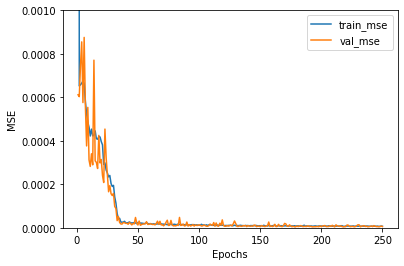

In [41]:
### Red-LSTM 1: trayectorias por y_gt = 0 = ROTEX

# multivariate output stacked lstm example
import numpy as np
from keras.models import Sequential
from keras.layers import *
from keras import Model
from keras.layers import LSTM, Bidirectional
from keras.layers import Dense, Dropout
from keras import optimizers
import matplotlib.pyplot as plt
 

# Formato deseado: (samples-timesteps-features)
X1 = np.zeros([0, n_steps, n_features])
Y1 = np.zeros([0,n_features])

traj1 = np.where(np.argmax(y_gt, axis=1)==0) # Trayectorias que pasan por Rotex

for i in traj1[0]:
	# define input sequence
  #in_seq1 = normalize_data(np.array(traj['altitude'][i]), 0, 40000)
  in_seq2 = normalize_data(np.array(traj['latitude'][i]), 35,45)
  in_seq3 = normalize_data(np.array(traj['longitude'][i]), -10, 3)
  #in_seq4 = normalize_data(np.array(traj['direction'][i]), 0, 360)
		
	# convert to [rows, columns] structure
  #in_seq1 = in_seq1.reshape((len(in_seq1), 1))
  in_seq2 = in_seq2.reshape((len(in_seq2), 1))
  in_seq3 = in_seq3.reshape((len(in_seq3), 1))
  #in_seq4 = in_seq4.reshape((len(in_seq4), 1))
	
	# horizontally stack columns
  sample_dataset = np.hstack((in_seq2, in_seq3))#inseq4
	# convert into input/output
  x, y = split_sequences(sample_dataset, n_steps)
  X1 = np.insert(X1, len(X1), x, axis=0) # añadimos en última posición
  Y1 = np.insert(Y1, len(Y1), y, axis=0)
	
X1 = X1.reshape((X1.shape[0], n_seq, n_steps_xseq, n_features))

#Define model
model1 = Sequential()
model1.add(TimeDistributed(Conv1D(filters=64, kernel_size=1, activation='relu'), input_shape=(None, n_steps_xseq, n_features)))
model1.add(TimeDistributed(Conv1D(filters=64, kernel_size=1, activation='relu')))
model1.add(TimeDistributed(MaxPooling1D()))
model1.add(TimeDistributed(Conv1D(filters=128, kernel_size=1, activation='relu')))
model1.add(TimeDistributed(Conv1D(filters=128, kernel_size=1, activation='relu')))
model1.add(TimeDistributed(GlobalMaxPooling1D()))
model1.add(TimeDistributed(Flatten()))
model1.add(Bidirectional(LSTM(64,activation = 'elu',kernel_initializer = 'glorot_normal',return_sequences=True,recurrent_dropout=0.2)))
model1.add(Bidirectional(LSTM(32,activation = 'elu',kernel_initializer = 'glorot_normal',recurrent_dropout=0.2)))
model1.add(Dense(16,activation = 'relu'))
model1.add(Dense(16,activation = 'relu'))
model1.add(Dense(8,activation = 'relu'))
model1.add(Dense(n_features))

#Load weights
#model.load_weights(files_path+model_path+'mv_traj_model1_weights.h5')
model1.compile(optimizer=optimizers.Adam(decay = lr/epochs,clipvalue = 1), loss='mse')

# fit model
H1 = model1.fit(X1, Y1, epochs=epochs, verbose=1, batch_size=batch_size, validation_split=validation_split)
#Save model
#model1.save(files_path+model_path+'mv_traj_model1.h5')

#Learning curves plot
train_mse_score = H1.history['loss']
validation_mse_score = H1.history['val_loss']
plt.plot(range(1, len(train_mse_score) + 1),train_mse_score)
plt.plot(range(1, len(validation_mse_score) + 1),validation_mse_score)
plt.xlabel('Epochs')
plt.legend(['train_mse','val_mse'])
plt.ylabel('MSE')
plt.ylim(0,0.0005)
plt.show()

In [0]:
model1.summary()


Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
time_distributed_36 (TimeDis (None, None, 10, 64)      192       
_________________________________________________________________
time_distributed_37 (TimeDis (None, None, 10, 64)      4160      
_________________________________________________________________
time_distributed_38 (TimeDis (None, None, 5, 64)       0         
_________________________________________________________________
time_distributed_39 (TimeDis (None, None, 5, 128)      8320      
_________________________________________________________________
time_distributed_40 (TimeDis (None, None, 5, 128)      16512     
_________________________________________________________________
time_distributed_41 (TimeDis (None, None, 128)         0         
_________________________________________________________________
time_distributed_42 (TimeDis (None, None, 128)        

Train on 9513 samples, validate on 2379 samples
Epoch 1/250
9513/9513 [==============================] - 18s 2ms/step - loss: 0.1421 - val_loss: 0.0587
Epoch 2/250
9513/9513 [==============================] - 3s 313us/step - loss: 0.0249 - val_loss: 0.0055
Epoch 3/250
9513/9513 [==============================] - 3s 291us/step - loss: 0.0030 - val_loss: 0.0021
Epoch 4/250
9513/9513 [==============================] - 3s 304us/step - loss: 0.0021 - val_loss: 0.0017
Epoch 5/250
9513/9513 [==============================] - 3s 303us/step - loss: 0.0018 - val_loss: 0.0014
Epoch 6/250
9513/9513 [==============================] - 3s 313us/step - loss: 0.0014 - val_loss: 0.0011
Epoch 7/250
9513/9513 [==============================] - 3s 299us/step - loss: 0.0012 - val_loss: 9.4195e-04
Epoch 8/250
9513/9513 [==============================] - 3s 306us/step - loss: 0.0010 - val_loss: 7.7047e-04
Epoch 9/250
9513/9513 [==============================] - 3s 299us/step - loss: 8.5825e-04 - val_loss: 6.2

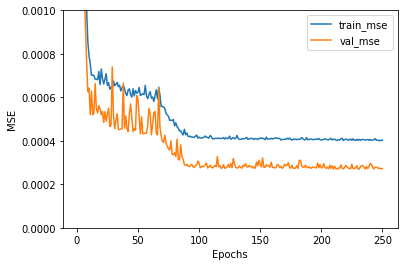

In [43]:
### Red-LSTM 2: trayectorias por y_gt = 1 = SANTA
import numpy as np
from keras.models import Sequential
from keras.layers import *
from keras.layers import LSTM, Bidirectional
from keras.layers import Dense, Dropout
from keras import optimizers
import matplotlib.pyplot as plt

# Formato deseado: (samples-timesteps-features)
X2 = np.zeros([0, n_steps, n_features])
Y2 = np.zeros([0,n_features])

traj2 = np.where(np.argmax(y_gt, axis=1)==1) # Trayectorias que pasan por Santa

for i in traj2[0]:
	# define input sequence
	#in_seq1 = normalize_data(np.array(traj['altitude'][i]), 0, 40000)
	in_seq2 = normalize_data(np.array(traj['latitude'][i]), 35,45)
	in_seq3 = normalize_data(np.array(traj['longitude'][i]), -10, 3)
	#in_seq4 = normalize_data(np.array(traj['direction'][i]), 0, 360)
	
	# convert to [rows, columns] structure
	#in_seq1 = in_seq1.reshape((len(in_seq1), 1))
	in_seq2 = in_seq2.reshape((len(in_seq2), 1))
	in_seq3 = in_seq3.reshape((len(in_seq3), 1))
	#in_seq4 = in_seq4.reshape((len(in_seq4), 1))

	# horizontally stack columns
	sample_dataset = np.hstack((in_seq2, in_seq3))#inseq4
	# convert into input/output
	x, y = split_sequences(sample_dataset, n_steps)
	X2 = np.insert(X2, len(X2), x, axis=0) # añadimos en última posición
	Y2 = np.insert(Y2, len(Y2), y, axis=0)
 
X2 = X2.reshape((X2.shape[0], n_seq, n_steps_xseq, n_features))

#Define model
model2 = Sequential()
model2.add(TimeDistributed(Conv1D(filters=64, kernel_size=1, activation='relu'), input_shape=(None, n_steps_xseq, n_features)))
model2.add(TimeDistributed(Conv1D(filters=64, kernel_size=1, activation='relu')))
model2.add(TimeDistributed(MaxPooling1D()))
model2.add(TimeDistributed(Conv1D(filters=128, kernel_size=1, activation='relu')))
model2.add(TimeDistributed(Conv1D(filters=128, kernel_size=1, activation='relu')))
model2.add(TimeDistributed(GlobalMaxPooling1D()))
model2.add(TimeDistributed(Flatten()))
model2.add(Bidirectional(LSTM(64,activation = 'elu',kernel_initializer = 'glorot_normal',return_sequences=True,recurrent_dropout=0.2)))
model2.add(Bidirectional(LSTM(32,activation = 'elu',kernel_initializer = 'glorot_normal',recurrent_dropout=0.2)))
model2.add(Dense(16,activation = 'relu'))
model2.add(Dense(16,activation = 'relu'))
model2.add(Dense(8,activation = 'relu'))
model2.add(Dense(n_features))

#Load weights
#mode2.load_weights(files_path+model_path+'mv_traj_model2_weights.h5')
model2.compile(optimizer=optimizers.Adam(decay = lr/epochs,clipvalue = 1), loss='mse')

# fit model
H2 = model2.fit(X2, Y2, epochs=epochs, verbose=1, batch_size=batch_size, validation_split=validation_split)
#Save model
#model2.save(files_path+model_path+'mv_traj_model2.h5')

#Learning curves plot
train_mse_score = H2.history['loss']
validation_mse_score = H2.history['val_loss']
plt.plot(range(1, len(train_mse_score) + 1),train_mse_score)
plt.plot(range(1, len(validation_mse_score) + 1),validation_mse_score)
plt.xlabel('Epochs')
plt.legend(['train_mse','val_mse'])
plt.ylabel('MSE')
plt.ylim(0,0.001)
plt.show()

### Pruebas

In [0]:
traj['latitude'][tr_id]

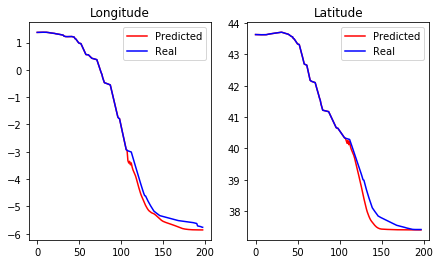

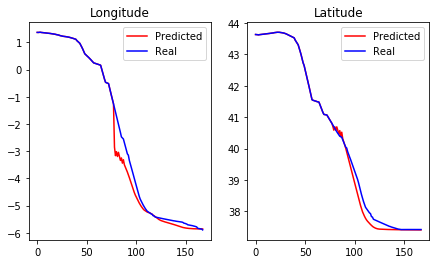

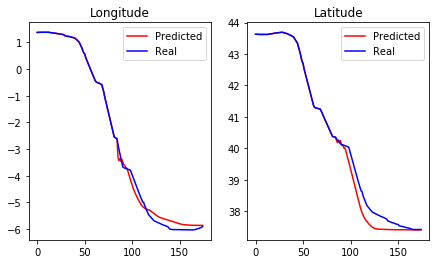

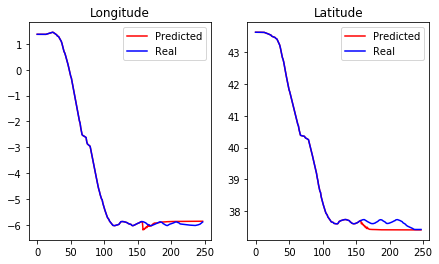

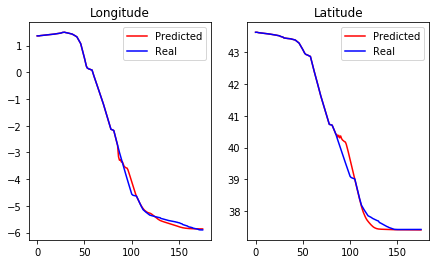

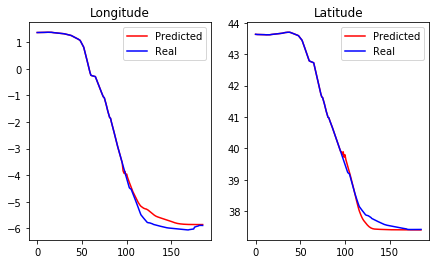

In [44]:
fl_id = np.random.randint(low=0, high=len(fl_id_list), size=(6,))
#model1 = load_model(files_path+model_path+'mv_traj_model1.h5')
#model2 = load_model(files_path+model_path+'mv_traj_model2.h5')

for idx,tr_id in enumerate(fl_id):
  last_measure = -90

  pred_lat, pred_lon, pred_alt,pred_dir = list(), list(), list(), list()

  #input_alt = normalize_data(np.array(traj['altitude'][tr_id][last_measure-n_steps:last_measure]), 0, 40000)
  input_lat = normalize_data(np.array(traj['latitude'][tr_id][last_measure-n_steps:last_measure]), 35, 45)
  input_lon = normalize_data(np.array(traj['longitude'][tr_id][last_measure-n_steps:last_measure]), -10, 3)
  #input_dir = normalize_data(np.array(traj['direction'][tr_id][last_measure-n_steps:last_measure]), 0, 360)

  dataset= np.array([input_lat, input_lon])#input_dir
  x_input = dataset.reshape((1,n_seq,n_steps_xseq,n_features))

  # Elegimos el modelo según la trayectoria
  if tr_id in traj1[0]: model = model1
  elif tr_id in traj2[0]: model = model2

  for i in range(abs(last_measure)):
    yhat = model.predict(x_input, verbose=0)

    #pred_alt.append(denormalize_data(yhat[0,0], 0, 40000))
    pred_lat.append(denormalize_data(yhat[0,0], 35, 45))
    pred_lon.append(denormalize_data(yhat[0,1], -10, 3))
    #pred_dir.append(denormalize_data(yhat[0,3], 0, 360))
    x_input = np.vstack([x_input[0][0], yhat[0]])[1:]
    x_input = x_input.reshape((1,n_seq,n_steps_xseq,n_features))


  #output_alt = np.concatenate([np.array(traj['altitude'][tr_id][:last_measure]), pred_alt])
  output_lat = np.concatenate([np.array(traj['latitude'][tr_id][:last_measure]), pred_lat])
  output_lon = np.concatenate([np.array(traj['longitude'][tr_id][:last_measure]), pred_lon])
  #output_dir = np.concatenate([np.array(traj['direction'][tr_id][:last_measure]), pred_dir])

  fig = plt.figure(figsize=(15, 4))
  ax = fig.add_subplot(141)

  labels = ['Predicted', 'Real']
  ax.title.set_text('Longitude')
  ax.plot(output_lon, 'r')
  ax.plot(traj['longitude'][tr_id], 'b')
  ax.legend(labels)
  #plt.ylim(35,45)

  ax = fig.add_subplot(142)
  ax.title.set_text('Latitude')
  ax.plot(output_lat, 'r')
  ax.plot(traj['latitude'][tr_id], 'b')
  ax.legend(labels)
  #plt.ylim(-10,3)

  """ax = fig.add_subplot(143)
  ax.title.set_text('Altitude')
  ax.plot(output_alt, 'r')
  ax.plot(traj['altitude'][tr_id], 'b')
  ax.legend(labels)

  ax = fig.add_subplot(144)
  ax.title.set_text('direction')
  ax.plot(output_dir, 'r')
  ax.plot(traj['direction'][tr_id], 'b')
  ax.legend(labels)"""
                     


In [0]:
from mpl_toolkits.basemap import Basemap

BBox = [-10, 2, 35, 45] # Longitud (min-max) y latitud (min-max)

fig = plt.figure(figsize=((BBox[1]-BBox[0]), BBox[3]-BBox[2]))
ax = fig.add_subplot(111)

ax.set_xlim((BBox[0], BBox[1]))
ax.set_ylim((BBox[2], BBox[3]))

m = Basemap(resolution='i', llcrnrlon=BBox[0], llcrnrlat=BBox[2], urcrnrlon=BBox[1], urcrnrlat=BBox[3], fix_aspect=False)
m.drawcoastlines()
m.drawcountries()

ax.plot(output_lon, output_lat, linewidth=0.5, c='r')
ax.plot(traj['longitude'][tr_id], traj['latitude'][tr_id], linewidth=0.5, c='b')

ax.legend(labels)
